# Measuring peformance in OpenCL applications

Having an understanding of how well OpenCL applications perform is a vital part of the development process. The two main tools, **profiling** and **tracing** collect information about how well an application is performing. **Profiling** is the statistical collection of the cumulative time that threads spend in each program component. **Tracing** is a collection of both **when** and **for how long** threads spend in each application component. While it is true that many vendors have largely abandoned their OpenCL performance measurement tools, the OpenCL standard itself provides a profiling interface and there are still a few open-source and commercial tools available.

## Event based profiling

Command queues have the ability to capture timing information for commands they process. In order to time commands submitted to an OpenCL command queue we enable a profiling flag **CL_QUEUE_PROFILING_ENABLE** during command queue creation. The time elap elapsed may be extracted directly from profiling events. In the code [mat_mult_profiling.cpp](mat_mult_profiling.cpp) we set the profiling flag to CL_TRUE.

```C++
    // mat_mult_profiling.cpp source

    // Do we enable profiling?
    cl_bool profiling = CL_TRUE;
```

Then from within **h_create_command_queues** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a>, the profiling flag CL_QUEUE_PROFILING_ENABLE is incorporated into the command queue properties and passed to [clCreateCommandQueue](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateCommandQueue.html).

```C++
    // cl_helper.hpp source

    // Manage bit fields for the command queue properties
    if (profiling_enable == CL_TRUE) {
        queue_properties = queue_properties | CL_QUEUE_PROFILING_ENABLE;    
    }

    // Allocate memory for the command queues
    cl_command_queue *command_queues = (cl_command_queue*)calloc(num_command_queues, sizeof(cl_command_queue));

    // Fill command queues in a Round-Robin fashion
    for (cl_uint n=0; n<num_command_queues; n++) {
        command_queues[n] = clCreateCommandQueue(
            contexts[n % num_devices],
            devices[n % num_devices],
            queue_properties,
            &errcode    
        );
        h_errchk(errcode, "Creating a command queue");        
    }
```

The function [clGetEventProfilingInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetEventProfilingInfo.html) extracts information such as start and end walltimes (in nanoseconds) for an OpenCL event associated with a queued command. We use the helper function **h_get_event_time_ms** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a> to extract the elapsed time.

```C++

// cl_helper.hpp source

cl_double h_get_event_time_ms(
        cl_event *event, 
        const char* message, 
        size_t* nbytes) {
    
    // Make sure the event has finished
    h_errchk(clWaitForEvents(1, event), message);
    
    // Start and end times
    cl_ulong t1, t2;
        
    // Fetch the start and end times in nanoseconds
    h_errchk(
        clGetEventProfilingInfo(
            *event,
            CL_PROFILING_COMMAND_START,
            sizeof(cl_ulong),
            &t1,
            NULL
        ),
        "Fetching start time for event"
    );

    h_errchk(
        clGetEventProfilingInfo(
            *event,
            CL_PROFILING_COMMAND_END,
            sizeof(cl_ulong),
            &t2,
            NULL
        ),
        "Fetching end time for event"
    );
    
    // Convert the time into milliseconds
    cl_double elapsed = (cl_double)(t2-t1)*(cl_double)1.0e-6;
        
    // Print the timing message if necessary
    if (strlen(message)>0) {
        std::printf("Time for event \"%s\": %.3f ms", message, elapsed);
        
        // Print transfer rate if nbytes is specified
        if (nbytes != NULL) {
            cl_double io_rate_MBs = h_get_io_rate_MBs(
                elapsed, 
                *nbytes
            );
            std::printf(" (%.2f MB/s)", io_rate_MBs);
        }
        std::printf("\n");
    }
    
    return elapsed;
}
```

Every command submitted to a command queue may have an event associated with it. We construct a **cl_event** object and use that event to collect timing information. For example, during buffer writes to device the following code goes from this

```C++
    // mat_mult.cpp source

    h_errchk(
        clEnqueueWriteBuffer(command_queue,
                            buffer_A,
                            blocking,
                            0,
                            nbytes_A,
                            array_A,
                            0,
                            NULL,
                            NULL), 
        "Writing to buffer_A from host"
    );
```

to this

```C++
    // mat_mult_profiling.cpp source

    // Event for the uploads and downloads
    cl_event io_event;
    
    h_errchk(
        clEnqueueWriteBuffer(command_queue,
                            buffer_A,
                            blocking,
                            0,
                            nbytes_A,
                            array_A,
                            0,
                            NULL,
                            &io_event), 
        "Writing to buffer_A from host"
    );

    // Time how long it takes to complete event
    cl_double upload_A_ms = h_get_event_time_ms(
        &io_event, 
        "Uploading Buffer A",
        &nbytes_A
    );
```

Similarly, the kernel enqueue code goes from this

```C++
    // mat_mult.cpp source

    // Event for the kernel
    cl_event kernel_event;

    // Now enqueue the kernel
    h_errchk(
        clEnqueueNDRangeKernel(command_queue,
                                kernel,
                                work_dim,
                                NULL,
                                global_size,
                                local_size,
                                0,
                                NULL,
                                &kernel_event), 
        "Running the kernel"
    );

    // Wait on the kernel to finish
    h_errchk(
        clWaitForEvents(1, &kernel_event),
        "Waiting on the kernel"
    );
```

to this

```C++
    // mat_mult_profiling.cpp source
    
    // Event for the kernel
    cl_event kernel_event;

    // Now enqueue the kernel
    h_errchk(
        clEnqueueNDRangeKernel(command_queue,
                                kernel,
                                work_dim,
                                NULL,
                                global_size,
                                local_size,
                                0,
                                NULL,
                                &kernel_event), 
        "Running the kernel"
    );

    // Time how long it takes to complete event
    cl_double run_kernel_ms = h_get_event_time_ms(
        &kernel_event, 
        "Running kernel",
        NULL
    );
```

In this manner we instrument the uploads, downloads, and kernel execution in the source file [mat_mult_profiling.cpp](mat_mult_profiling.cpp). Now we run the instrumented code and print out the results.

## Problem setup

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.make_data()

In [3]:
!make; ./mat_mult_profiling.exe -gpu

make: Nothing to be done for 'all'.
	               name: Tesla T4 
	 global memory size: 15634 MB
	    max buffer size: 3908 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Time for event "Uploading Buffer A": 0.087 ms (6099.71 MB/s)
Time for event "Uploading Buffer B": 0.174 ms (6079.53 MB/s)
Time for event "Running kernel": 8.942 ms
Time for event "Downloading Buffer C": 0.642 ms (3345.47 MB/s)


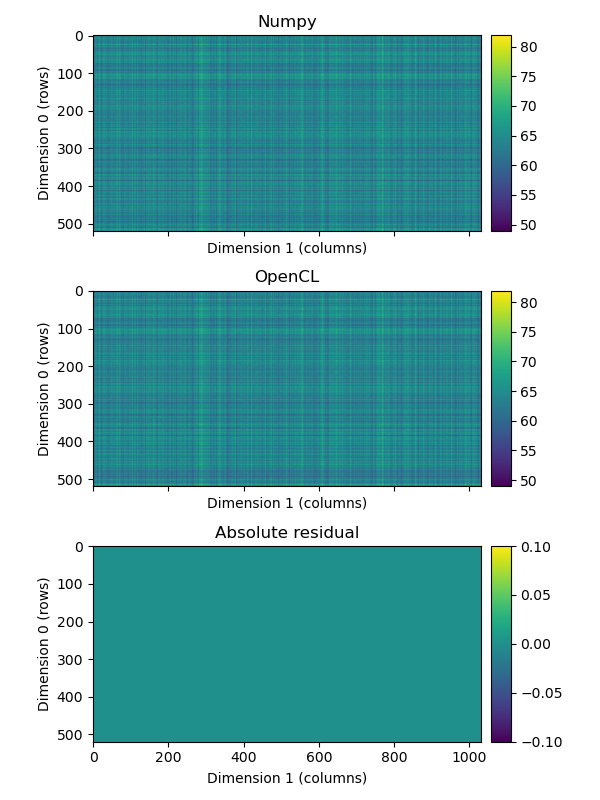

In [4]:
mat_mul.check_data()

## Open-source profiling tools

### Tau

[Tau](https://www.cs.uoregon.edu/research/tau/home.php) is a commonly used open-source profiling and tracing toolkit for HPC applications. For OpenCL applications it provides both profiling and tracing functionality.

#### Profiling

The Tau application **tau_exec** can be used to collect profiling information. Profiling information can then be visualised with the Tau applications **paraprof** (GUI), or **pprof** (command-line).

We set the environment variables **PROFILEDIR=./tau** to tell Tau where to put files.

In [5]:
%env PROFILEDIR=./tau

env: PROFILEDIR=./tau


Then we use the following call to **tau_exec** to collect profiling information for opencl calls.

In [10]:
!tau_exec -T serial -opencl ./mat_mult_profiling.exe

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
device id: -1629247368.
command id: 94891404868872.
vendor id: 0.
Got a bogus start! 2 .TAU application
Time for event "Uploading Buffer A": 0.216 ms (2461.77 MB/s)
Time for event "Uploading Buffer B": 0.323 ms (3268.10 MB/s)
Time for event "Running kernel": 53.618 ms
Time for event "Downloading Buffer C": 0.456 ms (4706.89 MB/s)


Now have a look at the contents of the tau directory

In [11]:
!ls ./tau

events.0.edf   profile.0.0.2  tau.trc		  tautrace.0.0.2.trc
profile.0.0.0  profile.txt    tautrace.0.0.0.trc  trace.json
profile.0.0.1  tau.edf	      tautrace.0.0.1.trc


Use the Tau application **pprof** to get a text mode profile of the app.

In [12]:
!pprof > ./tau/profile.txt

We see from the profile that the call to **mat_mult** took approximately **12ms**. This is similar to what was measured from the profiling interface.

#### Tracing with Google Chrome tracing

For tracing we set the environment variables **TRACEDIR=./tau** **TAU_TRACE=1**.

In [13]:
%env TAU_TRACE=1
%env TRACEDIR=./tau

env: TAU_TRACE=1
env: TRACEDIR=./tau


Capture OpenCL information as before

In [14]:
!tau_exec -T serial -opencl ./mat_mult_profiling.exe

	               name: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz 
	 global memory size: 16468 MB
	    max buffer size: 8234 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
device id: 2022348632.
command id: 94684603067064.
vendor id: 0.
Got a bogus start! 2 .TAU application
Time for event "Uploading Buffer A": 0.180 ms (2955.50 MB/s)
Time for event "Uploading Buffer B": 0.302 ms (3497.29 MB/s)
Time for event "Running kernel": 52.092 ms
Time for event "Downloading Buffer C": 0.499 ms (4305.15 MB/s)


Now merge the trace into a downloadable JSON document

In [15]:
!cd tau; echo 'y' | tau_treemerge.pl

/opt/tau/2.31.1/x86_64/bin/tau_merge -m tau.edf -e events.0.edf events.0.edf events.0.edf tautrace.0.0.0.trc tautrace.0.0.1.trc tautrace.0.0.2.trc tau.trc
tau.trc exists; override [y]? tautrace.0.0.0.trc: 418 records read.
tautrace.0.0.1.trc: 6 records read.
tautrace.0.0.2.trc: 41 records read.


In [16]:
!cd tau; tau_trace2json ./tau.trc ./tau.edf -chrome -ignoreatomic -o trace.json

Using the file manager on the left download the file in **tau/trace.json** to your computer. Then in the Chrome browser you can go to the address

```http
chrome://tracing
```

and load the trace for viewing on your local machine. 


<figure style="margin-left:0; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/Chrome_trace.png">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Google Chrome tracing render.</figcaption>
</figure>

In this instance we see that the kernel **mat_mult** has taken approximately 22ms to complete.

## Commercial profiling tools

### CLTracer

[CLTracer](https://www.cltracer.com/) is a commerical product that profiles OpenCL calls for Windows and Linux OpenCL applications. It requires a GUI to run and provides 

* A timeline of OpenCL calls, separated into API and kernel calls
* Tables of time spent in each call
    * Global and local kernel size recorded
    * Size of transfers recorded
* Time spent in the API vs time spent blocking
* Breakdown of time spent in kernels
* Breakdown of time spent in queues

Setting up project settings and running a trace for [mat_mult_profiling.cpp](mat_mult_profiling.cpp) was really easy. Unfortunately I don't see the ability to fetch information from the command line.

#### Timeline view

The timeline view shows when and for how long each OpenCL call lasts. The overview shows that setting 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/cltracer_timeline_overview.png">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">CLTracer timeline overview.</figcaption>
</figure>

If we zoom in to the kernel region we see that executing the kernel only took around 2.9ms and that it takes less time to upload and download arrays than the kernel spends executing.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/cltracer_timeline_zoom.png">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">CLTracer timeline, zoomed in on kernel region.</figcaption>
</figure>

#### Tables

The timeline can also be viewed in tabular format. In addition to times for each OpenCL call you can see global and local sizes of the kernels as well as the size of kernel uploads and downloads.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/cltracer_tables.png">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">CLTracer table of OpenCL calls.</figcaption>
</figure>

For more information on available tools within CLTracer please see the CLTracer [Documentation](https://www.cltracer.com/docs).

## Vendor profiling tools

### AMD

#### HSA application traces

```bash
rocprof --hsa-trace -o amd_profiles/result.csv ./mat_mult_profiling.exe
```

Then in Google Chrome go to the address

chrome://tracing

to load **result.json**

#### Performance counters

Rocprof can collect performance counters on kernels. We specify a list of counters and the kernels they should apply to in the file **[rocprof_counters.txt](rocprof_counters.txt)**

```bash
rocprof -i rocprof_counters.txt --timestamp on --stats -o amd_profiles/result.csv ./mat_mult_profiling.exe
```

### NVIDIA

#### Profiling with nvprof

Historically there was limited functionality for profiling OpenCL events with NVIDIA's [NVVP](http://uob-hpc.github.io/2015/05/27/nvvp-import-opencl.html), however profiling support for OpenCL has largely disappeared, with the implementation of Nsight Compute and Nsight systems.




<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the Pawsey Supercomputing Centre
</address>